In [23]:
import pandas as pd
import numpy as np

# Load Data
# df = pd.read_csv('./data_set.csv', delimiter=',')
# df['Avg_TotalPassengerCount_3yr_round'] = df['Avg_TotalPassengerCount_3yr'].round(0)
# df['Avg_BoothsUsed_3yr_round'] = df['Avg_BoothsUsed_3yr'].round(0)

df = pd.read_csv('./dataset_hourly.csv', delimiter=',')

df['Avg_Passengers_Hourly'] = df['Avg_PassengersHour_3yr'].round(0)
df['Avg_Booths_Hourly'] = df['Avg_BoothsHour_3yr'].round(0)

df

,week_index,day_index,Shift,Hour,Avg_PassengersHour_3yr,Avg_BoothsHour_3yr,Avg_Passengers_Hourly,Avg_Booths_Hourly
0,1,1,00-08,0,116.500000,5.500000,116.0,6.0
1,1,1,00-08,1,233.666667,5.666667,234.0,6.0
2,1,1,00-08,2,135.000000,4.000000,135.0,4.0
3,1,1,00-08,3,188.000000,6.000000,188.0,6.0
4,1,1,00-08,4,134.000000,6.000000,134.0,6.0
...,...,...,...,...,...,...,...,...
835,5,7,16-00,19,881.500000,13.000000,882.0,13.0
836,5,7,16-00,20,648.333333,15.000000,648.0,15.0
837,5,7,16-00,21,326.000000,10.333333,326.0,10.0
838,5,7,16-00,22,334.000000,7.333333,334.0,7.0


In [97]:
from gurobipy import Model, GRB, quicksum
from collections import defaultdict

# =========================
# 0. Sets & Indices
# =========================

W = range(1, 6)   # weeks: 1..5
D = range(1, 8)   # days: 1..7
S = range(1, 4)   # shifts: 1..3
H = range(0, 24)  # hours: 0...23

# Map from each shift to shift index
shift_map = {
    "00-08": 1,
    "08-16": 2,
    "16-00": 3
}


# =========================
# 1. Parameters
# =========================

# A[w][d][s][h]: passenger arrivals (average among 2022-2024)

# --- Step 1: build A and mu only from real data ---
A = {}
mu = {}

for _, row in df.iterrows():
    w = int(row["week_index"])       # 1~5
    d = int(row["day_index"])        # 1~7
    s = shift_map[row["Shift"]]      # 1,2,3
    h = int(row["Hour"])             # 0~23 (but aligned with shift)

    # passenger arrivals
    A[(w, d, s, h)] = row["Avg_Passengers_Hourly"]

    # service rate per booth
    booths = row["Avg_Booths_Hourly"]
    demand = row["Avg_Passengers_Hourly"]

    if booths > 0:
        mu[(w, d, s, h)] = demand / booths
    else:
        mu[(w, d, s, h)] = 0.0

# --- Step 2: time_slots = all real (w,d,s,h) combinations in df ---
time_slots = sorted(A.keys(), key=lambda t: (t[0], t[1], t[2], t[3]))

# Other Parameters
B_max = 30                           # booth max number
c_r = 20.0                           # regular wage per hour
c_o = 30.0                           # overtime wage per hour
Budget_w = {w: 40000.0 for w in W}   # weekly budget
alpha = 0.4                          # the weight, needed to be adjusted

# BacklogThreshold = 800.0             # threshold of backlog in each shift
# lam = 800                            # backlog penalty


# =========================
# 2. Model
# =========================

m = Model("Airport_Staffing_Christmas")


# =========================
# 3. Decision Variables
# =========================

# x_wds: regular booths in shift
x = m.addVars(time_slots, vtype=GRB.INTEGER, lb=0, name="x")

# o_wds: overtime booths in shift
o = m.addVars(time_slots, vtype=GRB.INTEGER, lb=0, name="o")

# u_wds: passengers processed in shift
u = m.addVars(time_slots, vtype=GRB.INTEGER, lb=0, name="u")

# b_wds: backlog after this shift
b = m.addVars(time_slots, vtype=GRB.INTEGER, lb=0, name="b")

# # z equals to 1 if penalty is activated in this shift. Otherwise, 0.
# z = m.addVars(time_slots, vtype=GRB.BINARY, name="z")


# =========================
# 4. Constraints
# =========================

# ---------- 4.0 Group hours by (w,d,s) ----------
hours_by_wds = defaultdict(list)
for (w_t, d_t, s_t, h_t) in time_slots:
    hours_by_wds[(w_t, d_t, s_t)].append(h_t)

# ---------- 4.A Flow balance ----------
# b_{t} = A_{t} + b_{t-1} - u_{t}
# u_{t} ≤ A_{t} + b_{t-1}
for idx, (w, d, s, h) in enumerate(time_slots):

    if idx == 0:
        # very first hour: no historical backlog
        backlog_in = 0.0
    else:
        w_prev, d_prev, s_prev, h_prev = time_slots[idx - 1]
        backlog_in = b[(w_prev, d_prev, s_prev, h_prev)]

    # (1) demand capacity: processed cannot exceed arrivals + backlog_in
    m.addConstr(
        u[(w, d, s, h)] <= A[(w, d, s, h)] + backlog_in,
        name=f"DemandCap_{w}_{d}_{s}_{h}"
    )

    # (2) backlog balance
    m.addConstr(
        b[(w, d, s, h)] == A[(w, d, s, h)] + backlog_in - u[(w, d, s, h)],
        name=f"BacklogBal_{w}_{d}_{s}_{h}"
    )

# ---------- helpers for previous shift ----------
prev_shift = {1: 3, 2: 1, 3: 2}  # 1<-3<-2<-1 cycle

shift_base_hour = {
    1: 0,   # 00–08
    2: 8,   # 08–16
    3: 16   # 16–24
}

# ---------- 4.B Service capacity + overtime structure ----------
# Rules:
#  R1: o_{wds h} ≤ x_{prev shift}   (hour-level bound)
#  R2: u_{wds h} ≤ μ_{wds h} · ( x_{wds}^{base} + o_{wds h} )
#  R3: Σ_h o_{wds h} ≤ 2 · x_{prev shift}

for (w, d, s), hours in hours_by_wds.items():
    hours = sorted(hours)

    # base hour for current shift (for regular booths)
    ideal_base_h = shift_base_hour[s]
    base_h = ideal_base_h if ideal_base_h in hours else hours[0]

    # ---- figure out previous shift (w_prev, d_prev, s_prev) ----
    s_prev = prev_shift[s]

    # default: no previous regular booths
    prev_regular = 0

    if not (w == 1 and d == 1 and s == 1):
        if s == 1:
            # current = shift 1 → previous = shift 3 of previous day
            if d == 1:
                w_prev = w - 1
                d_prev = 7
            else:
                w_prev = w
                d_prev = d - 1
        else:
            # current = shift 2 or 3 → previous shift is same day
            w_prev = w
            d_prev = d

        # hours of previous shift
        hours_prev = sorted(hours_by_wds[(w_prev, d_prev, s_prev)])
        ideal_prev_base = shift_base_hour[s_prev]
        prev_base_h = ideal_prev_base if ideal_prev_base in hours_prev else hours_prev[0]

        # regular booths in previous shift (shift-level)
        prev_regular = x[(w_prev, d_prev, s_prev, prev_base_h)]

    # ---- (R1 + R2) apply for each hour in current shift ----
    for h in hours:
        # (R1) hour-level overtime cannot exceed previous shift's regular booths
        m.addConstr(
            o[(w, d, s, h)] <= prev_regular,
            name=f"OT_hourCap_{w}_{d}_{s}_{h}"
        )

        # (R2) service capacity: u ≤ μ · (regular + overtime)
        m.addConstr(
            u[(w, d, s, h)] <= mu[(w, d, s, h)] * (x[(w, d, s, base_h)] + o[(w, d, s, h)]),
            name=f"ServiceCap_{w}_{d}_{s}_{h}"
        )

    # ---- (R3) total overtime-hours per shift ≤ 2 × prev_regular ----
    m.addConstr(
        quicksum(o[(w, d, s, h)] for h in hours) <= 2 * prev_regular,
        name=f"OT_totalCap_{w}_{d}_{s}"
    )

# ---------- 4.C Hourly homogenization for regular booths ----------
# x_{wds h} = x_{wds, base_h} 
# This is used to maintain number of booths in each hours in one shift in a stable state.
# In this case, it cannot happen for 1st hour has 20 booths opened but only 2 booths opened in the 2nd hour.

for (w, d, s), hours in hours_by_wds.items():
    hours = sorted(hours)
    ideal_base_h = shift_base_hour[s]
    base_h = ideal_base_h if ideal_base_h in hours else hours[0]

    for h in hours:
        if h == base_h:
            continue
        m.addConstr(
            x[(w, d, s, h)] == x[(w, d, s, base_h)],
            name=f"LinkX_{w}_{d}_{s}_{h}"
        )

# ---------- 4.D Booth capacity ----------
for (w, d, s, h) in time_slots:
    m.addConstr(
        x[(w, d, s, h)] <= B_max,
        name=f"BoothCap_{w}_{d}_{s}_{h}"
    )


# ---- 4.E Weekly Budget ----
# Σ_{d,s,h} ( x_wds·c_r + o_wds·c_o + penalty) ≤ Budget_w
for w in W:
    m.addConstr(
        quicksum(
            x[(ww, d, s, h)] * c_r +
            o[(ww, d, s, h)] * c_o
            for (ww, d, s, h) in time_slots
            if ww == w
        ) <= Budget_w[w],
        name=f"WeeklyBudget_{w}"
    )


# =========================
# 5. Objective
# =========================
# Minimize Σ cost, regular working hour costs and overtime costs

m.setObjective(quicksum(((1 - alpha) * (c_r * x[(w, d, s, h)] + c_o * o[(w, d, s, h)])
                         + alpha * b[(w, d, s, h)])
                        for (w, d, s, h) in time_slots), GRB.MINIMIZE)


# =========================
# 6. Solver Settings
# =========================

m.Params.MIPGap = 0.01   # ≤ gap
m.Params.TimeLimit = 600  # time limit


# =========================
# 7. Optimize
# =========================

m.optimize()    


# =========================
# 8. Print Outputs
# =========================

if m.status == GRB.OPTIMAL or m.status == GRB.TIME_LIMIT:
    print(f"Objective value = {m.ObjVal:.2f}")
    # x, o, u, b in each week, day, shift, hour
    for (w, d, s, h) in time_slots:
        A_val = A[(w, d, s, h)]
        mu_val = mu[(w, d, s, h)]
        
        x_val = x[(w, d, s, h)].X
        o_val = o[(w, d, s, h)].X
        u_val = u[(w, d, s, h)].X
        b_val = b[(w, d, s, h)].X
        if x_val > 0.1 or o_val > 0.1 or u_val > 0.1 or b_val > 0.1:
            print(f"Week {w}, Day {d}, Shift {s}, Hour {h}: "
                  f"A={A_val:6.1f}, mu={mu_val:6.3f}, "
                  f"x={x_val:.1f}, o={o_val:.1f}, "
                  f"u={u_val:.1f}, b={b_val:.1f}")
else:
    m.computeIIS()
    m.write("infeasible_model.ilp")

Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 600
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 25.1.0 25B78)

CPU model: Apple M3
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  600
MIPGap  0.01

Optimize a model with 5045 rows, 3360 columns and 13324 nonzeros
Model fingerprint: 0xf605b137
Variable types: 0 continuous, 3360 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [4e-01, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+01, 4e+04]
Found heuristic solution: objective 5.934448e+07
Presolve removed 2425 rows and 1374 columns
Presolve time: 0.01s
Presolved: 2620 rows, 1986 columns, 8775 nonzeros
Variable types: 0 continuous, 1986 integer (0 binary)

Root relaxation: objective 1.188542e+05, 1649 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 E

Saved: plots_shift_level/x_heatmap.png


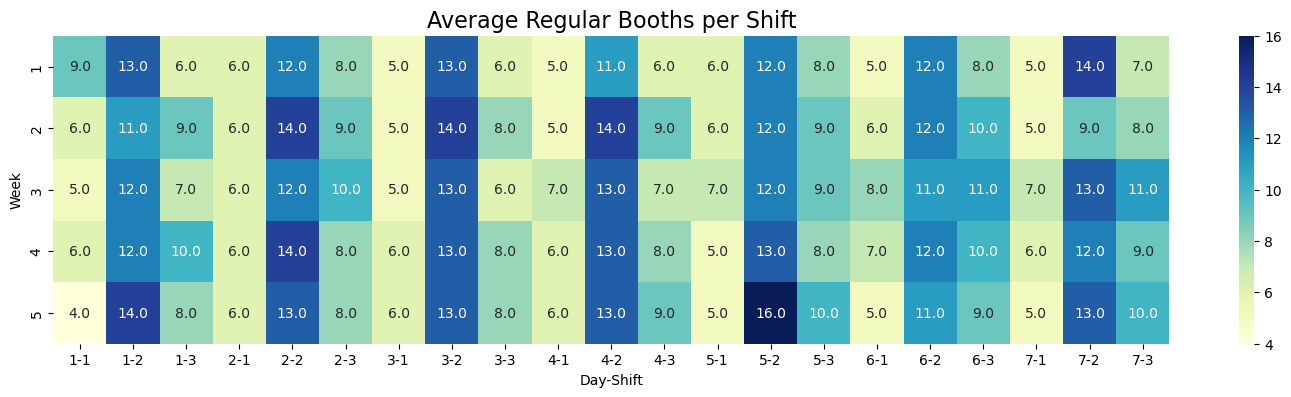

Saved: plots_shift_level/o_heatmap.png


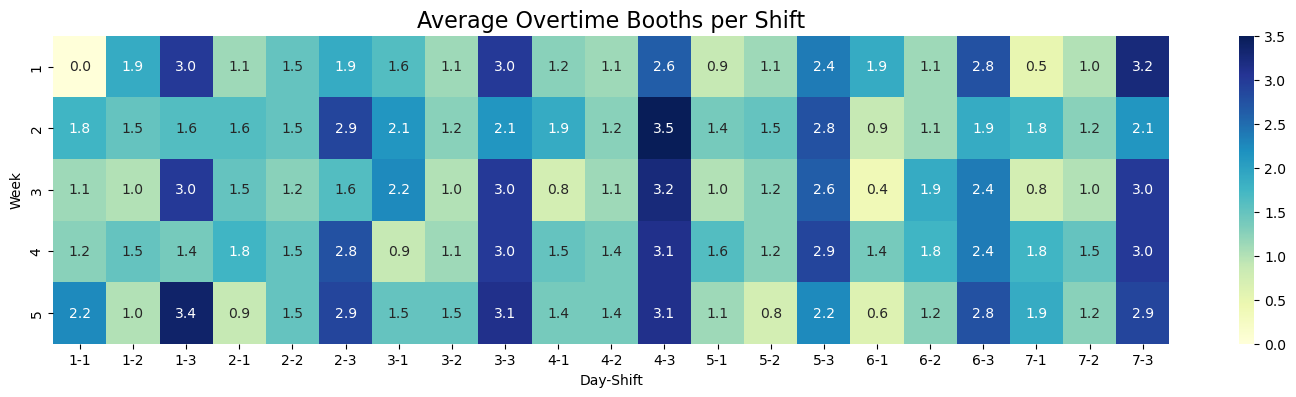

Saved: plots_shift_level/u_heatmap.png


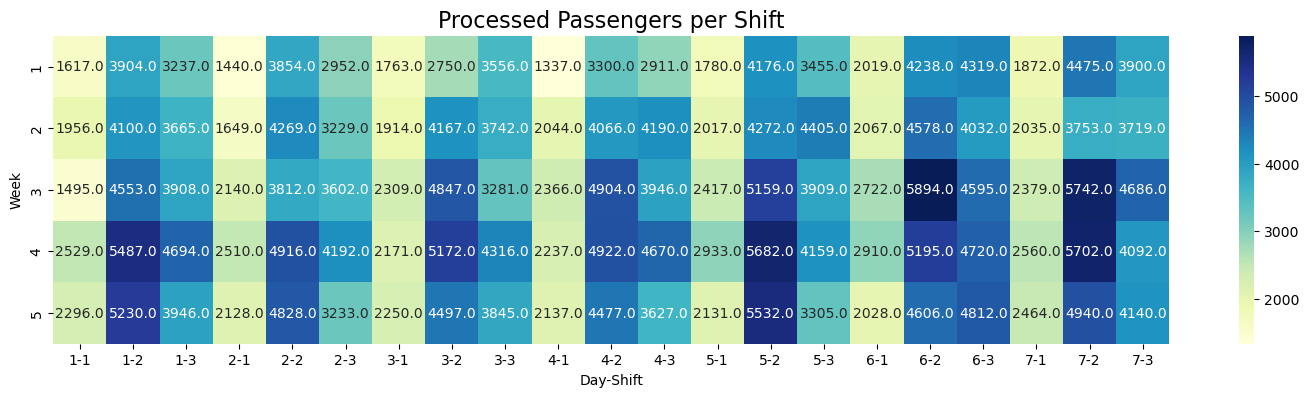

Saved: plots_shift_level/b_heatmap.png


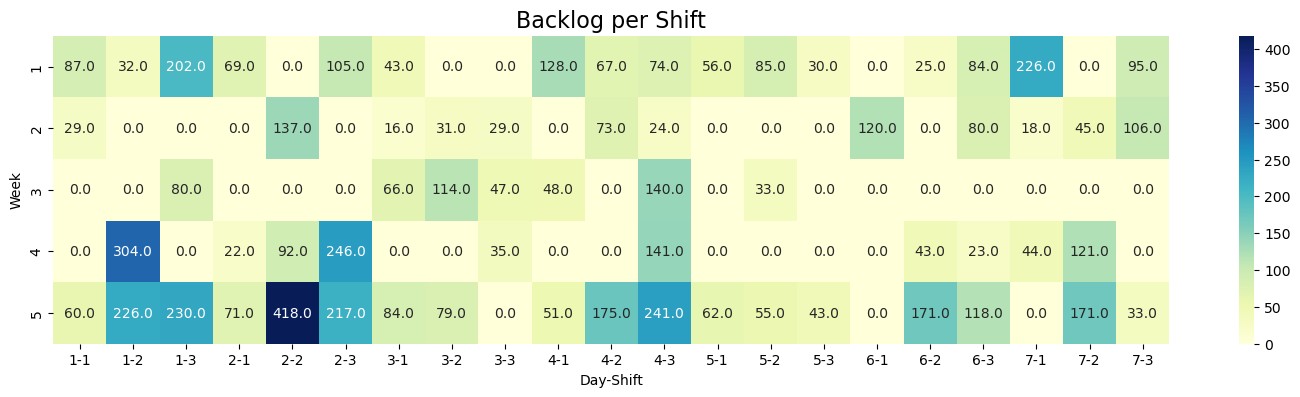

In [89]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

# ============================
# 1. Convert hour-level → shift-level
# ============================

results = []

for (w, d, s, h) in time_slots:
    results.append({
        "week": w,
        "day": d,
        "shift": s,
        "hour": h,
        "x": x[(w, d, s, h)].X,
        "o": o[(w, d, s, h)].X,
        "u": u[(w, d, s, h)].X,
        "b": b[(w, d, s, h)].X
    })

df_res = pd.DataFrame(results)

# ---- NEW: average x and o, sum u and b ----
df_shift = df_res.groupby(['week','day','shift']).agg({
    "x": "mean",
    "o": "mean",
    "u": "sum",
    "b": "sum"
}).reset_index()

df_shift['slot'] = df_shift['day'].astype(str) + "-" + df_shift['shift'].astype(str)


# ============================
# 2. Create output directory
# ============================

save_dir = "plots_shift_level"
os.makedirs(save_dir, exist_ok=True)


# ============================
# 3. Heatmap function: draw + download
# ============================

def plot_heatmap_shift(df, variable, title):
    pivot_table = df.pivot(index='week', columns='slot', values=variable)

    plt.figure(figsize=(18, 4))
    sns.heatmap(pivot_table, annot=True, fmt=".1f", cmap="YlGnBu")
    plt.title(title, fontsize=16)
    plt.xlabel("Day-Shift")
    plt.ylabel("Week")

    filename = f"{save_dir}/{variable}_heatmap.png"
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    print(f"Saved: {filename}")

    plt.show()
    plt.close()


# ============================
# 4. Generate & Save All Heatmaps
# ============================

plot_heatmap_shift(df_shift, "x", "Average Regular Booths per Shift")
plot_heatmap_shift(df_shift, "o", "Average Overtime Booths per Shift")
plot_heatmap_shift(df_shift, "u", "Processed Passengers per Shift")
plot_heatmap_shift(df_shift, "b", "Backlog per Shift")
